# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [255]:
import requests
import json

import pandas as pd
import numpy as np
import time
import seaborn as sns
from datetime import datetime
from sklearn.metrics import accuracy_score , f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [159]:
URL = "http://www.reddit.com/hot.json"

In [160]:
res = requests.get(URL, headers={'User-agent': 'Bushra Bot 0.1'})

In [161]:
res.status_code

200

In [162]:
res.text[:500]

'{"kind": "Listing", "data": {"modhash": "", "dist": 25, "children": [{"kind": "t3", "data": {"approved_at_utc": null, "subreddit": "wholesomememes", "selftext": "", "author_fullname": "t2_1odig92c", "saved": false, "mod_reason_title": null, "gilded": 0, "clicked": false, "title": "We don\'t deserve Bob Ross", "link_flair_richtext": [], "subreddit_name_prefixed": "r/wholesomememes", "hidden": false, "pwls": 6, "link_flair_css_class": null, "downs": 0, "thumbnail_height": 140, "hide_score": false, '

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [163]:
data = res.json()

In [164]:
print(len(data['data']['children']))

25


In [165]:
data.keys()

dict_keys(['kind', 'data'])

In [166]:
data['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'wholesomememes',
   'selftext': '',
   'author_fullname': 't2_1odig92c',
   'saved': False,
   'mod_reason_title': None,
   'gilded': 0,
   'clicked': False,
   'title': "We don't deserve Bob Ross",
   'link_flair_richtext': [],
   'subreddit_name_prefixed': 'r/wholesomememes',
   'hidden': False,
   'pwls': 6,
   'link_flair_css_class': None,
   'downs': 0,
   'thumbnail_height': 140,
   'hide_score': False,
   'name': 't3_9g5942',
   'quarantine': False,
   'link_flair_text_color': 'dark',
   'author_flair_background_color': None,
   'subreddit_type': 'public',
   'ups': 30559,
   'domain': 'i.redd.it',
   'media_embed': {},
   'thumbnail_width': 140,
   'author_flair_template_id': None,
   'is_original_content': False,
   'user_reports': [],
   'secure_media': None,
   'is_reddit_media_domain': True,
   'is_meta': False,
   'category': None,
   'secure_media_embed': {},
   'link_flair_text': None,
   'can_mod_post'

In [167]:
data['data']['children'][0]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'author_flair_background_color', 'subreddit_type', 'ups', 'domain', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'banned_by', 'author_flair_type', 'contest_mode', 'selftext_html', 'likes', 'suggested_sort', 'banned_at_utc', 'view_count', 'archived', 'no_follow', 'is_crosspostable', 'pinned', 'over_18', 'preview',

In [168]:
# scrapedids = pd.DataFrame(data['data']['children'])
results = []
for child in data['data']['children']:
    results.append(child['data'])
#     scrapedids.append(child['data']['title']['subreddit']['created_utc']['num_comments'])
df = pd.DataFrame(results)
df.head()

,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,None,None,False,katsonka,None,None,[],None,None,None,...,140.0,140.0,We don't deserve Bob Ross,30559,https://i.redd.it/9zsctboz2hm11.jpg,[],None,False,all_ads,6
1,None,None,False,Palifaith,None,None,[],None,None,None,...,133.0,140.0,Login: admin Password: admin,33941,https://i.imgur.com/gjNPCBY.jpg,[],None,False,all_ads,6
2,None,None,False,Incondite,None,None,[],None,None,None,...,140.0,140.0,[Schefter] Browns are releasing WR Josh Gordon...,6101,https://twitter.com/AdamSchefter/status/104110...,[],None,False,all_ads,6
3,None,None,False,SeattleMana,None,None,[],None,None,None,...,78.0,140.0,Get a husky they said. It will be fun they said.,33923,https://i.imgur.com/O3fiH3a.gifv,[],None,False,all_ads,6
4,None,None,False,BoarderGod,None,None,[],None,None,None,...,105.0,140.0,"Found this mushroom while hiking in the woods,...",18045,https://i.redd.it/n91897aqrgm11.jpg,[],None,False,all_ads,6


In [172]:
#Acquiring The required pieces of information about each thread:
#The title of the thread>>> title
#The subreddit that the thread corresponds to>>> subreddit
#The length of time it has been up on Reddit>>> created_utc  
#The number of comments on the thread>>> num_comments

parsed_df=pd.DataFrame()
parsed_df = df[['title','subreddit','created_utc','num_comments']]
parsed_df.head()

,title,subreddit,created_utc,num_comments
0,We don't deserve Bob Ross,wholesomememes,1.537048e+09,440
1,Login: admin Password: admin,funny,1.537046e+09,262
2,[Schefter] Browns are releasing WR Josh Gordon...,fantasyfootball,1.537054e+09,2235
3,Get a husky they said. It will be fun they said.,aww,1.537044e+09,903
4,"Found this mushroom while hiking in the woods,...",pics,1.537044e+09,347


#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [174]:
for i in range (110):
    url= "http://www.reddit.com/hot.json?after="+data['data']['after']
    res = requests.get(url, headers = {'User-agent': 'Bushra Bot 0.1'})
    time.sleep(3)
    time_fetched = pd.Timestamp.utcnow()
    data = res.json()
    posts = [child['data'] for child in data['data']['children']]
    parsed_df = pd.concat([pd.DataFrame(posts),parsed_df],axis=0, sort=True)
    parsed_df['time_fetched'] = time_fetched

In [175]:
# data['data']['after']

In [176]:
parsed_df.shape

(2775, 98)

In [177]:
parsed_df.head()

,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,thumbnail_width,time_fetched,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,None,None,False,mojave955,NaN,,SouthKorea,[],None,,...,140.0,2018-09-16 02:45:24.051159+00:00,Driver of K2 Black Panther having the time of ...,852.0,https://gfycat.com/VeneratedDifficultChrysalis,[],None,False,all_ads,6.0
1,None,None,False,creeperfilms,NaN,,meltdownrin3,[],486838e0-6d94-11e2-a470-12313b0d44ba,,...,140.0,2018-09-16 02:45:24.051159+00:00,Reactor by サワシ,180.0,https://i.redd.it/t33fe561dfm11.jpg,[],None,False,None,NaN
2,None,None,False,luis_mcy,NaN,None,None,[],None,None,...,140.0,2018-09-16 02:45:24.051159+00:00,Yesterday right after sunset Tampa skyline 🌇,178.0,https://i.redd.it/pgd31vm5dfm11.jpg,[],None,False,all_ads,6.0
3,None,None,False,DammitPantera,NaN,None,None,[],None,None,...,140.0,2018-09-16 02:45:24.051159+00:00,About to have a mad threesome with two hotties...,176.0,http://imgur.com/YhNWiEO,[],None,False,all_ads,6.0
4,None,None,False,Bleeding_Choker,NaN,None,None,[],None,None,...,140.0,2018-09-16 02:45:24.051159+00:00,Dracon Female Fighter by Mad 1984,56.0,https://cdna.artstation.com/p/assets/images/im...,[],None,False,None,NaN


## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [184]:
# Make a dataframe has the four required features+ extra features from my choice

final_df = pd.DataFrame(parsed_df)

required_ = ['title','subreddit','created_utc','num_comments']
extra_ = ['score','subreddit_subscribers','category','subreddit_type','ups','num_reports','num_crossposts']

final_df[required_ + extra_]


final_df = final_df[required_ + extra_]

final_df.head()

,title,subreddit,created_utc,num_comments,score,subreddit_subscribers,category,subreddit_type,ups,num_reports,num_crossposts
0,Driver of K2 Black Panther having the time of ...,MilitaryGfys,1.537009e+09,65,852.0,86651.0,None,public,852.0,None,0.0
1,Reactor by サワシ,Vocaloid,1.537027e+09,3,180.0,19546.0,None,public,180.0,None,0.0
2,Yesterday right after sunset Tampa skyline 🌇,tampa,1.537027e+09,4,178.0,26940.0,None,public,178.0,None,0.0
3,About to have a mad threesome with two hotties...,exjw,1.537028e+09,44,176.0,25716.0,None,public,176.0,None,0.0
4,Dracon Female Fighter by Mad 1984,ImaginaryMonsterGirls,1.537050e+09,2,56.0,8823.0,None,public,56.0,None,1.0


### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [185]:
# Export to csv
final_df.to_csv("scraped_reddit_data.csv", index=False)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [186]:
scr_data = pd.read_csv("scraped_reddit_data.csv")
scr_data = scr_data.sort_values(by='num_comments', ascending=False)

In [188]:
scr_data.head()

,title,subreddit,created_utc,num_comments,score,subreddit_subscribers,category,subreddit_type,ups,num_reports,num_crossposts
2722,What is something in YOUR life that is SUPER F...,AskReddit,1.537005e+09,17951,54123.0,20107954.0,NaN,public,54123.0,NaN,4.0
558,[Game Thread] TCU vs. Ohio State (8:00PM ET),CFB,1.537052e+09,10394,483.0,481150.0,NaN,public,483.0,NaN,0.0
1152,People who received no or terrible sex educati...,AskReddit,1.537030e+09,9425,26747.0,20107982.0,NaN,public,26747.0,NaN,2.0
1477,People who received no or terrible sex educati...,AskReddit,1.537030e+09,9419,26697.0,20107972.0,NaN,public,26697.0,NaN,2.0
2202,People who received no or terrible sex educati...,AskReddit,1.537030e+09,9386,26608.0,20107960.0,NaN,public,26608.0,NaN,2.0


In [194]:
print('Number of Posts = {} \nFeatures for each post = {}'.format(scr_data.shape[0],scr_data.shape[1]))

Number of Posts = 2775 
Features for each post = 11


In [189]:
# check data type
scr_data.dtypes

title                     object
subreddit                 object
created_utc              float64
num_comments               int64
score                    float64
subreddit_subscribers    float64
category                  object
subreddit_type            object
ups                      float64
num_reports              float64
num_crossposts           float64
dtype: object

In [190]:
# change type of (created_utc) to Datetime
scr_data['created_utc']=pd.to_datetime(scr_data.created_utc, unit='s',infer_datetime_format=True)
scr_data.dtypes

title                            object
subreddit                        object
created_utc              datetime64[ns]
num_comments                      int64
score                           float64
subreddit_subscribers           float64
category                         object
subreddit_type                   object
ups                             float64
num_reports                     float64
num_crossposts                  float64
dtype: object

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [195]:
# I will choose (median) as a  splitting point:

# check (num_comments) statistics to get the median (50%)
scr_data['num_comments'].describe()

count     2775.000000
mean       145.871351
std        644.118924
min          0.000000
25%          9.000000
50%         25.000000
75%         75.000000
max      17951.000000
Name: num_comments, dtype: float64

In [196]:
#another way to get the median
scr_data.num_comments.median()

25.0

In [197]:
#create a new binary variable that is true when the number of comments is high (above the median)
scr_data['is_high'] = [1 if x > scr_data.num_comments.median() else 0 for x in scr_data.num_comments]

In [199]:
scr_data['is_high'].value_counts()

0    1424
1    1351
Name: is_high, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [202]:
# In baseline model I will select the class that has the most observations which is (0: below median)
# Baseline accuracy for the model with a traget (below median)

In [203]:
scr_data.is_high.value_counts(normalize=True)

0    0.513153
1    0.486847
Name: is_high, dtype: float64

In [206]:
# prediction 
y_pred = [0]*scr_data.shape[0]
y = scr_data.is_high

# accuracy
baseline_accuracy = accuracy_score(y, y_pred)
baseline_accuracy

0.5131531531531531

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [207]:
# create a Random Forest model to predict number of comments below the median
# using the subreddit as a feature >>> should convert to dummies


In [208]:
# Convert (subreddit) to dummies and assign those dummies to X as predictors
X = pd.get_dummies(scr_data.subreddit)
X.shape

(2775, 1110)

In [209]:
# assign y value
y = scr_data['is_high']

In [212]:
# Hyperparamter Tuning using GridSearch

RF_parameters = {"n_estimators": [18, 27, 36, 45],
              "max_depth": [15, 20, 25, 30, 35, 40],
              "max_features": ['auto', 'sqrt']}

RF_grid_search = GridSearchCV(RandomForestClassifier(), RF_parameters, cv=5, verbose=1 )
results = RF_grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


In [213]:
# Check best paramters 
results.best_params_

{'max_depth': 35, 'max_features': 'sqrt', 'n_estimators': 27}

In [214]:
# Use the best estimator
RF_accuracy1 = cross_val_score(results.best_estimator_, X, y, cv=5).mean()
RF_accuracy1

0.6118680046693449

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

#### Part1: 
##### create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title then build  a new Random Forest with these features.

In [218]:
# create a feature that represents whether 'cat' is in the title
scr_data['cat']=scr_data['title'].map(lambda x: 1 if x.lower().find('cat')>=0 else 0)

In [219]:
scr_data['cat'].value_counts()

0    2724
1      51
Name: cat, dtype: int64

In [220]:
# create a feature that represents whether 'funny' is in the title
scr_data['funny']=scr_data['title'].map(lambda x: 1 if x.lower().find('funny')>=0 else 0)

In [221]:
scr_data['funny'].value_counts()

0    2769
1       6
Name: funny, dtype: int64

In [ ]:
# create a Random Forest model to predict number of comments below the median
# using the subreddit as a feature + two new features (cat - funny)

In [222]:
# add the two new features to X which has (subreddit) already
X['cat']=scr_data.cat
X['funny']=scr_data.funny

# assign y value
y = scr_data['is_high']


In [223]:
# Hyperparamter Tuning using GridSearch

RF_parameters = {"n_estimators": [18, 27, 36, 45],
              "max_depth": [15, 20, 25, 30, 35, 40],
              "max_features": ['auto', 'sqrt']}

RF_grid_search = GridSearchCV(RandomForestClassifier(), RF_parameters, cv=5, verbose=1 )
results = RF_grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   51.1s finished


In [224]:
# Check best paramters 
results.best_params_

{'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 27}

In [225]:
# Use the best estimator
RF_accuracy2 = cross_val_score(results.best_estimator_, X, y, cv=5).mean()
RF_accuracy2

0.6006903287985281

#### Part2:
##### use count-vectorizer to create features based on the words in the thread titles then Build a new random forest model with subreddit and these new features included.

In [227]:
# use count-vectorizer to create features based on the words in the thread titles
cvec = CountVectorizer(stop_words='english')
vectorized = cvec.fit_transform(scr_data['title'])

In [228]:
## move it to data frame
word_df  = pd.DataFrame(vectorized.todense(),
                   columns=cvec.get_feature_names(),
                   )

word_df.head(2)

,00,000,00pm,01100101,01101001,01110010,01110011,01110100,015,06,...,zoomies,zucchini,zuckerberg,zyklon,är,że,ɐᴉllɐɹʇs,ほろくさ,サワシ,𝘩𝘦𝘭𝘭𝘰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
# merge features
# (word_df) has vectorized features + (X) has subreddit, Cat and Funny features

In [231]:
X.shape

(2775, 1111)

In [233]:
word_df.shape

(2775, 5789)

In [234]:
#merging
X=pd.concat([X,word_df],axis=1)
X.head(2)

,1200isfineIGUESSugh,2meirl42meirl4meirl,2meirl4meirl,3Dprinting,40kLore,4PanelCringe,4Runner,4x4,6thForm,90DayFiance,...,zoomies,zucchini,zuckerberg,zyklon,är,że,ɐᴉllɐɹʇs,ほろくさ,サワシ,𝘩𝘦𝘭𝘭𝘰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
X.shape

(2775, 6900)

In [237]:
# create a Random Forest model to predict number of comments below the median
# using the subreddit as a feature + two new features (cat - funny) + victorized features

In [238]:
# X is assigned in the last step (subreddit + (cat - funny) + victorized features)
# assign y value
y = scr_data['is_high']

In [239]:
# Hyperparamter Tuning using GridSearch

RF_parameters = {"n_estimators": [18, 27, 36, 45],
              "max_depth": [15, 20, 25, 30, 35, 40],
              "max_features": ['auto', 'sqrt']}

RF_grid_search = GridSearchCV(RandomForestClassifier(), RF_parameters, cv=5, verbose=1 )
results = RF_grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.3min finished


In [240]:
# Check best paramters 
results.best_params_

{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 36}

In [241]:
# Use the best estimator
RF_accuracy3 = cross_val_score(results.best_estimator_, X, y, cv=5).mean()
RF_accuracy3

0.5581859609395126

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [ ]:
## YOUR CODE HERE

#### Repeat the model-building process with a non-tree-based method.

In [242]:
# I will use Logistic Regression Model to predict number of comments below the median
# using the subreddit as a feature + two new features (cat - funny) + victorized features

In [243]:
# X is assigned above to: (subreddit + (cat - funny) + victorized features)
# assign y value
y = scr_data['is_high']

In [248]:
# Hyperparamter Tuning using GridSearch

log_parameters = {'C' : np.logspace(-6, 2, 20)}

log_grid_search = GridSearchCV(LogisticRegression(), log_parameters, cv=5, verbose=1 )
results = log_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   37.9s finished


In [249]:
# Check best paramters 
results.best_params_

{'C': 5.455594781168514}

In [250]:
# Use the best estimator
LR_accuracy = cross_val_score(results.best_estimator_, X, y, cv=5).mean()
LR_accuracy

0.5866220322600345

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [251]:
# In order to know the most valuable features (from the thread titles),
#we need to find the correlation between these features and the target

In [252]:
# make a new dataframe which has the target (num_comments) and victorized features
#and find the correlation
new_df = pd.concat([word_df,scr_data['num_comments']], axis=1).corr()

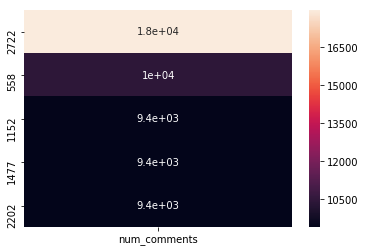

In [257]:
# get the top 5 correlated variables with the target
top_5 = 5
top_corr = pd.DataFrame(scr_data.nlargest(top_5, 'num_comments')['num_comments'])
sns.heatmap(top_corr, annot=True);

# Executive Summary
---
Put your executive summary in a Markdown cell below.

* The goal of this project was to predict if a theard post on Reddit will get a High number of comments or Not.
* The total observations obtained from (Reddit) website were: 2775 posts.
* I converted the number of comments to a binary classification variable, then use the median of comments number to classify comments to high and low.
* I fit different models using different features:


Knowing that Baseline Accuracy was: 0.5131531531531531

In [265]:
print('1. The score of using Random Forest model with following features:\n    Subreddit\n\n    {}'.format(RF_accuracy1))
print('\n2. The score of using Random Forest model with following features:\n    Subreddit + the appearance of (cat and funny) in the title of the thread\n\n    {}'.format(RF_accuracy2))
print('\n3. The score of using Random Forest model with following features:\n    Subreddit + the appearance of (cat and funny) in the title of the thread + count of words appeared in title\n\n    {}'.format(RF_accuracy3))
print('\n4. The score of using Logistic Regression model with following features:\n    Subreddit + the appearance of (cat and funny) in the title of the thread + count of words appeared in title\n\n    {}'.format(LR_accuracy))


1. The score of using Random Forest model with following features:
    Subreddit

    0.6118680046693449

2. The score of using Random Forest model with following features:
    Subreddit + the appearance of (cat and funny) in the title of the thread

    0.6006903287985281

3. The score of using Random Forest model with following features:
    Subreddit + the appearance of (cat and funny) in the title of the thread + count of words appeared in title

    0.5581859609395126

4. The score of using Logistic Regression model with following features:
    Subreddit + the appearance of (cat and funny) in the title of the thread + count of words appeared in title

    0.5866220322600345


#### From above we conclude that the best score was when we use Random Forest model with (subriddit), and adding extra features or using Logistic Regression didn't add any significant value.



### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE